## Multi-label prediction with Planet Amazon dataset

In [1]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 576.5MB 28kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x625ce000 @  0x7fac819c92a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 122kB 3.8MB/s 
    100% |████████████████████████████████| 61kB 6.1MB/s 
    100% |████████████████████████████████| 112kB 5.6MB/s 
    100% |████████████████████████████████| 163kB 5.4MB/s 
  Running setup.py bdist_wheel for bottleneck ... - \ | / - \ | / done
  Stored in directory: /root/.cache/pip/wheels/f2/bf/ec/e0f39aa27001525ad455139ee57ec7d0776fe074dfd78c97e4
Successfully built bottleneck
torchvision-nightly 0.2.1 has requirement pillow>=4.1.1, 

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

## Getting the data

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course-v3.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [4]:
! pip install kaggle --upgrade

    100% |████████████████████████████████| 61kB 2.8MB/s 
    100% |████████████████████████████████| 245kB 5.2MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/8b/21/3b/a0076243c6ae12a6215b2da515fe06b539aee7217b406e510e
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal).

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"datajhonny","key":"868f24119d6b14f1dcdc4b17761336c1"}'}

In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [9]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /root/.cache/pip/wheels/17/0f/04/b79c006972335e35472c0b835ed52bfc0815258d409f560108
Successfully built gputil
  Running setup.py bdist_wheel for humanize ... - done
  Stored in directory: /root/.cache/pip/wheels/69/86/6c/f8b8593bc273ec4b0c653d3827f7482bb2001a2781a73b7f44
Successfully built humanize


In [10]:
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.9 GB  | Proc size: 276.1 MB
GPU RAM Free: 11430MB | Used: 11MB | Util   0% | Total 11441MB


You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [11]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [12]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

 98% 591M/600M [00:06<00:00, 166MB/s]
100% 600M/600M [00:06<00:00, 101MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 46.0MB/s]


In [13]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}
! 7za -bd -y x {path}/test-jpg-additional.tar.7z -o{path}
! tar -xf {path}/test-jpg-additional.tar -C {path}
! rsync -aP {path}/test-jpg-additional/ {path}/test-jpg/

 94% 285M/304M [00:02<00:00, 45.0MB/s]
100% 304M/304M [00:03<00:00, 104MB/s] 

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
1 file, 318407195 bytes (304 MiB)

Extracting archive: /root/.fastai/data/planet/test-jpg-additional.tar.7z
--
Path = /root/.fastai/data/planet/test-jpg-additional.tar.7z
Type = 7z
Physical Size = 318407195
Headers Size = 98
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       336865280
Compressed: 318407195
sending incremental file list
created directory /root/.fastai/data/planet/test-jpg
./
file_0.jpg
         17,995 100%    0.00kB/s    0:00:00 (xfr#1, to-chk=20521/20523)
file_1.jpg
         18,608 100%   17.75MB/s    0:00:00 (xfr#2, to-chk=20520/20523)
file_10.jpg
          6,980 100%    6.66MB/s    0:00:00 (xfr#3, to-chk=20519/20523)
file_100.jpg
         15

To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip` in your terminal).

In [17]:
!pip3 install -y -c haasad eidl7zip


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -y


And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

In [0]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

In [16]:
!ls

sample_data


## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [19]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageMultiDataset` (and not `ImageClassificationDataset`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [0]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' '))

In [24]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

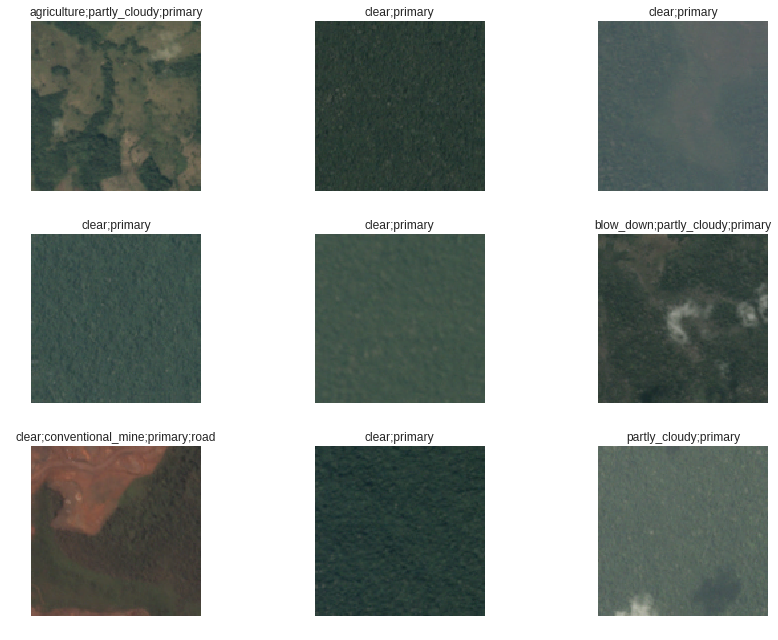

In [25]:
data.show_batch(rows=3, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet34 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [0]:
arch = models.resnet50

In [27]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 73643582.41it/s]


We use the LR Finder to pick a good learning rate.

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


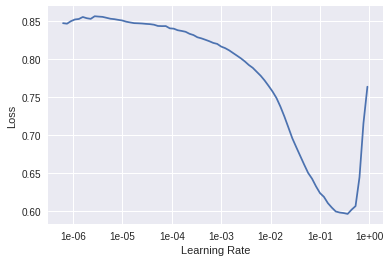

In [0]:
learn.recorder.plot()

Then we can fit the head of our network.

In [0]:
lr = 0.01

In [29]:
learn.fit_one_cycle(5, slice(lr))

Total time: 19:55
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.117706    0.103708    0.952810         0.909967  (03:55)
2      0.107572    0.097333    0.955892         0.914340  (03:44)
3      0.100883    0.092695    0.956691         0.916776  (03:56)
4      0.095194    0.085475    0.955906         0.928282  (04:03)
5      0.087151    0.084503    0.957294         0.927380  (04:15)



In [0]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [31]:
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.7 GB  | Proc size: 2.1 GB
GPU RAM Free: 8575MB | Used: 2866MB | Util  25% | Total 11441MB


In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


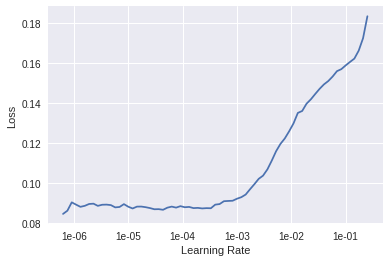

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 23:54
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.095681    0.089475    0.956800         0.923289  (04:46)
2      0.096799    0.089172    0.955710         0.920551  (04:47)
3      0.088312    0.085534    0.958493         0.925956  (04:47)
4      0.088019    0.083160    0.958682         0.928535  (04:46)
5      0.081485    0.082684    0.958369         0.928628  (04:46)



In [33]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 23:26
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.095164    0.090260    0.954271         0.922148  (04:40)
2      0.095855    0.088254    0.956633         0.923997  (04:40)
3      0.090217    0.085883    0.958347         0.926843  (04:42)
4      0.083752    0.082981    0.960251         0.928925  (04:39)
5      0.080199    0.081968    0.959431         0.930206  (04:42)



In [34]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.7 GB  | Proc size: 2.1 GB
GPU RAM Free: 8295MB | Used: 3146MB | Util  27% | Total 11441MB


In [0]:
learn.save('stage-2-rn50')

In [0]:
learn.load('stage-2-rn50')

In [36]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


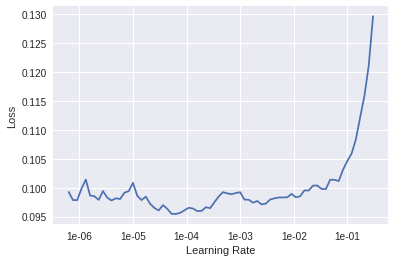

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2

In [0]:
learn.fit_one_cycle(5, slice(lr))

Total time: 57:17
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.087597    0.085990    0.959721         0.925129  (11:39)
2      0.086427    0.087246    0.956000         0.921134  (11:24)
3      0.086083    0.082040    0.958994         0.929071  (11:23)
4      0.082099    0.081234    0.959205         0.929723  (11:25)
5      0.080540    0.080842    0.958972         0.930468  (11:25)



In [38]:
learn.fit_one_cycle(5, slice(lr))

Total time: 55:17
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.093364    0.090622    0.957439         0.920092  (11:20)
2      0.094496    0.095432    0.957876         0.916891  (10:59)
3      0.090826    0.087004    0.956328         0.924814  (10:59)
4      0.084921    0.081178    0.959598         0.930602  (10:59)
5      0.083143    0.082213    0.959161         0.930887  (10:59)



In [0]:
learn.save('stage-1-256-rn50')

In [6]:
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.7 GB  | Proc size: 2.0 GB
GPU RAM Free: 10933MB | Used: 508MB | Util   4% | Total 11441MB


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path
df = pd.read_csv(path/'train_v2.csv')
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' '))
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))
arch = models.resnet50
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

In [3]:
learn.load('stage-1-256-rn50')

Learner(data=ImageDataBunch;
Train: LabelList
y: MultiCategoryList (32384 items)
[MultiCategory haze;primary, MultiCategory clear;primary, MultiCategory clear;primary, MultiCategory haze;primary;water, MultiCategory agriculture;clear;cultivation;primary;water]...
Path: /root/.fastai/data/planet
x: ImageItemList (32384 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /root/.fastai/data/planet;
Valid: LabelList
y: MultiCategoryList (8095 items)
[MultiCategory clear;primary;road, MultiCategory clear;primary;water, MultiCategory clear;conventional_mine;habitation;primary;road;water, MultiCategory cloudy, MultiCategory agriculture;clear;cultivation;cultivation;habitation;primary;road;water]...
Path: /root/.fastai/data/planet
x: ImageItemList (8095 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /root/.fastai/data/planet;
Test: None, model=Sequent

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 25:04
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.153162    0.111301    0.953573         0.908727  (05:13)
2      0.101680    0.091989    0.956153         0.919866  (04:56)
3      0.093002    0.086953    0.957381         0.925459  (04:56)
4      0.089201    0.084798    0.958551         0.926536  (04:57)
5      0.085671    0.083628    0.958776         0.927751  (04:59)



In [9]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 24:02
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.136499    0.102115    0.953704         0.914290  (04:57)
2      0.100868    0.091166    0.955158         0.920629  (04:44)
3      0.095641    0.087297    0.958050         0.922529  (04:47)
4      0.088220    0.084035    0.959045         0.927943  (04:48)
5      0.087438    0.083451    0.960440         0.928376  (04:44)



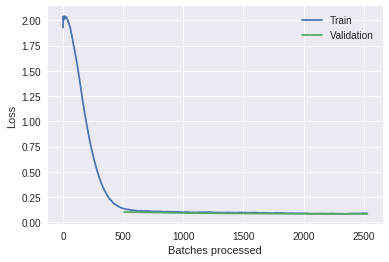

In [10]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

## fin

(We'll look at this section later - please don't ask about it just yet! :) )

In [12]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}

 98% 589M/603M [00:05<00:00, 90.1MB/s]
100% 603M/603M [00:05<00:00, 123MB/s] 


In [13]:
learn.load('stage-2-256-rn50')

Learner(data=ImageDataBunch;
Train: LabelList
y: MultiCategoryList (32384 items)
[MultiCategory haze;primary, MultiCategory clear;primary, MultiCategory clear;primary, MultiCategory haze;primary;water, MultiCategory agriculture;clear;cultivation;primary;water]...
Path: /root/.fastai/data/planet
x: ImageItemList (32384 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /root/.fastai/data/planet;
Valid: LabelList
y: MultiCategoryList (8095 items)
[MultiCategory clear;primary;road, MultiCategory clear;primary;water, MultiCategory clear;conventional_mine;habitation;primary;road;water, MultiCategory cloudy, MultiCategory agriculture;clear;cultivation;cultivation;habitation;primary;road;water]...
Path: /root/.fastai/data/planet
x: ImageItemList (8095 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /root/.fastai/data/planet;
Test: None, model=Sequent

In [0]:
learn.data = (src.add_test_folder('test-jpg')
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

In [17]:
len(learn.data.train_ds)

32384

In [18]:
len(learn.data.valid_ds)

8095

In [19]:
len(learn.data.test_ds)

61191

In [20]:
predictions = learn.TTA(ds_type=DatasetType.Test)[0]

Total time: 1:36:41



In [0]:
torch.save(predictions,'predictions_sz_256.pt')

In [22]:
predictions.shape

torch.Size([61191, 17])

In [23]:
len(predictions[0])

17

In [0]:
def find_tags(pred, thresh):
    classes = ""
    for idx, val in enumerate(pred):
        if val > thresh:
            classes = f'{classes} {learn.data.classes[idx]}'
    return classes.strip()

In [0]:
def predict(idx):
    pred_vals = predictions[0][idx]
    tags = find_tags(pred_vals, 0.2)
    print(tags)
    img = learn.data.test_ds[idx][0]
    return img

In [0]:
def get_row(idx):
    pred = predictions[idx]
    tags = find_tags(pred, 0.2)
    image_path = learn.data.test_ds.x.items[idx]
    image_name = re.search(r'([^/]+)$', f'{image_path}')[0].replace('.jpg', '')
    
    return image_name, tags

In [28]:
get_row(0)

('file_15679', 'clear primary road')

In [29]:
df = pd.DataFrame(columns=['image_name', 'tags'])
for idx in range(len(predictions)):
    if idx % 1000 == 0:
        print(f"Completed: {idx}")
        
    image_name, tags = get_row(idx)
    df.loc[idx] = [image_name, tags]

Completed: 0
Completed: 1000
Completed: 2000
Completed: 3000
Completed: 4000
Completed: 5000
Completed: 6000
Completed: 7000
Completed: 8000
Completed: 9000
Completed: 10000
Completed: 11000
Completed: 12000
Completed: 13000
Completed: 14000
Completed: 15000
Completed: 16000
Completed: 17000
Completed: 18000
Completed: 19000
Completed: 20000
Completed: 21000
Completed: 22000
Completed: 23000
Completed: 24000
Completed: 25000
Completed: 26000
Completed: 27000
Completed: 28000
Completed: 29000
Completed: 30000
Completed: 31000
Completed: 32000
Completed: 33000
Completed: 34000
Completed: 35000
Completed: 36000
Completed: 37000
Completed: 38000
Completed: 39000
Completed: 40000
Completed: 41000
Completed: 42000
Completed: 43000
Completed: 44000
Completed: 45000
Completed: 46000
Completed: 47000
Completed: 48000
Completed: 49000
Completed: 50000
Completed: 51000
Completed: 52000
Completed: 53000
Completed: 54000
Completed: 55000
Completed: 56000
Completed: 57000
Completed: 58000
Completed:

In [0]:
submission_path = 'submission_fastai_1.0.27_sz_256_val_0.2.csv'
df.to_csv(submission_path, index=False)

In [31]:
!kaggle competitions submit -c planet-understanding-the-amazon-from-space -f submission_fastai_1.0.27_sz_256_val_0.2.csv -m "Message"

100% 2.41M/2.41M [00:00<00:00, 6.28MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space